# Examen Final



El objetivo principal es predecir el flujo de calor crítico (CHF) en sistemas de ebullición bifásica, basandonos en el paper *On the prediction of critical heat flux using a physics-informed machine learning-aided framework*, para lograr este objetivo vamos a utilizar :

- Modelos de machine learning (Linear Regression, Random Forest y Redes Neuronales),


La predicción del CHF se hace usando las siguientes variables independientes:

- Presión (P)

- Flujo másico (G)

- Calidad del flujo (xe)

- Diámetro hidráulico (De)

- Diámetro calefaccionado (Dh)

- Longitud calefaccionada (Lh)

Y el target es:

- CHF (flujo de calor crítico experimental)

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

## Cargando Datos

In [31]:
df = pd.read_csv("Data_CHF_Zhao_2020_ATE.csv")

In [33]:
df.head()

,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,1,Inasaka,tube,0.39,5600,-0.1041,3.0,3.0,100,11.3
1,2,Inasaka,tube,0.31,6700,-0.0596,3.0,3.0,100,10.6
2,3,Inasaka,tube,0.33,4300,-0.0395,3.0,3.0,100,7.3
3,4,Inasaka,tube,0.62,6400,-0.1460,3.0,3.0,100,12.8
4,5,Inasaka,tube,0.64,4700,-0.0849,3.0,3.0,100,11.0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1865 entries, 0 to 1864
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1865 non-null   int64  
 1   author               1865 non-null   object 
 2   geometry             1865 non-null   object 
 3   pressure [MPa]       1865 non-null   float64
 4   mass_flux [kg/m2-s]  1865 non-null   int64  
 5   x_e_out [-]          1865 non-null   float64
 6   D_e [mm]             1865 non-null   float64
 7   D_h [mm]             1865 non-null   float64
 8   length [mm]          1865 non-null   int64  
 9   chf_exp [MW/m2]      1865 non-null   float64
dtypes: float64(5), int64(3), object(2)
memory usage: 145.8+ KB


### Crear nuevas features 

Vamos a agregar algunas features derivadas que aparecen en el paper y que tienen relación física:

- length_to_diameter = $\frac{length}{D_h}$

- D_ratio =  $\frac{D_e}{D_h}$

Potencialmente interacciones como mass_flux * x_e_out o términos cuadráticos.

In [37]:
df['length_to_diameter'] = df['length [mm]'] / df['D_h [mm]']
df['D_ratio'] = df['D_e [mm]'] / df['D_h [mm]']

In [39]:
numerical_cols = [
    'pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
    'D_e [mm]', 'D_h [mm]', 'length [mm]', 'chf_exp [MW/m2]',
    'length_to_diameter', 'D_ratio'
]

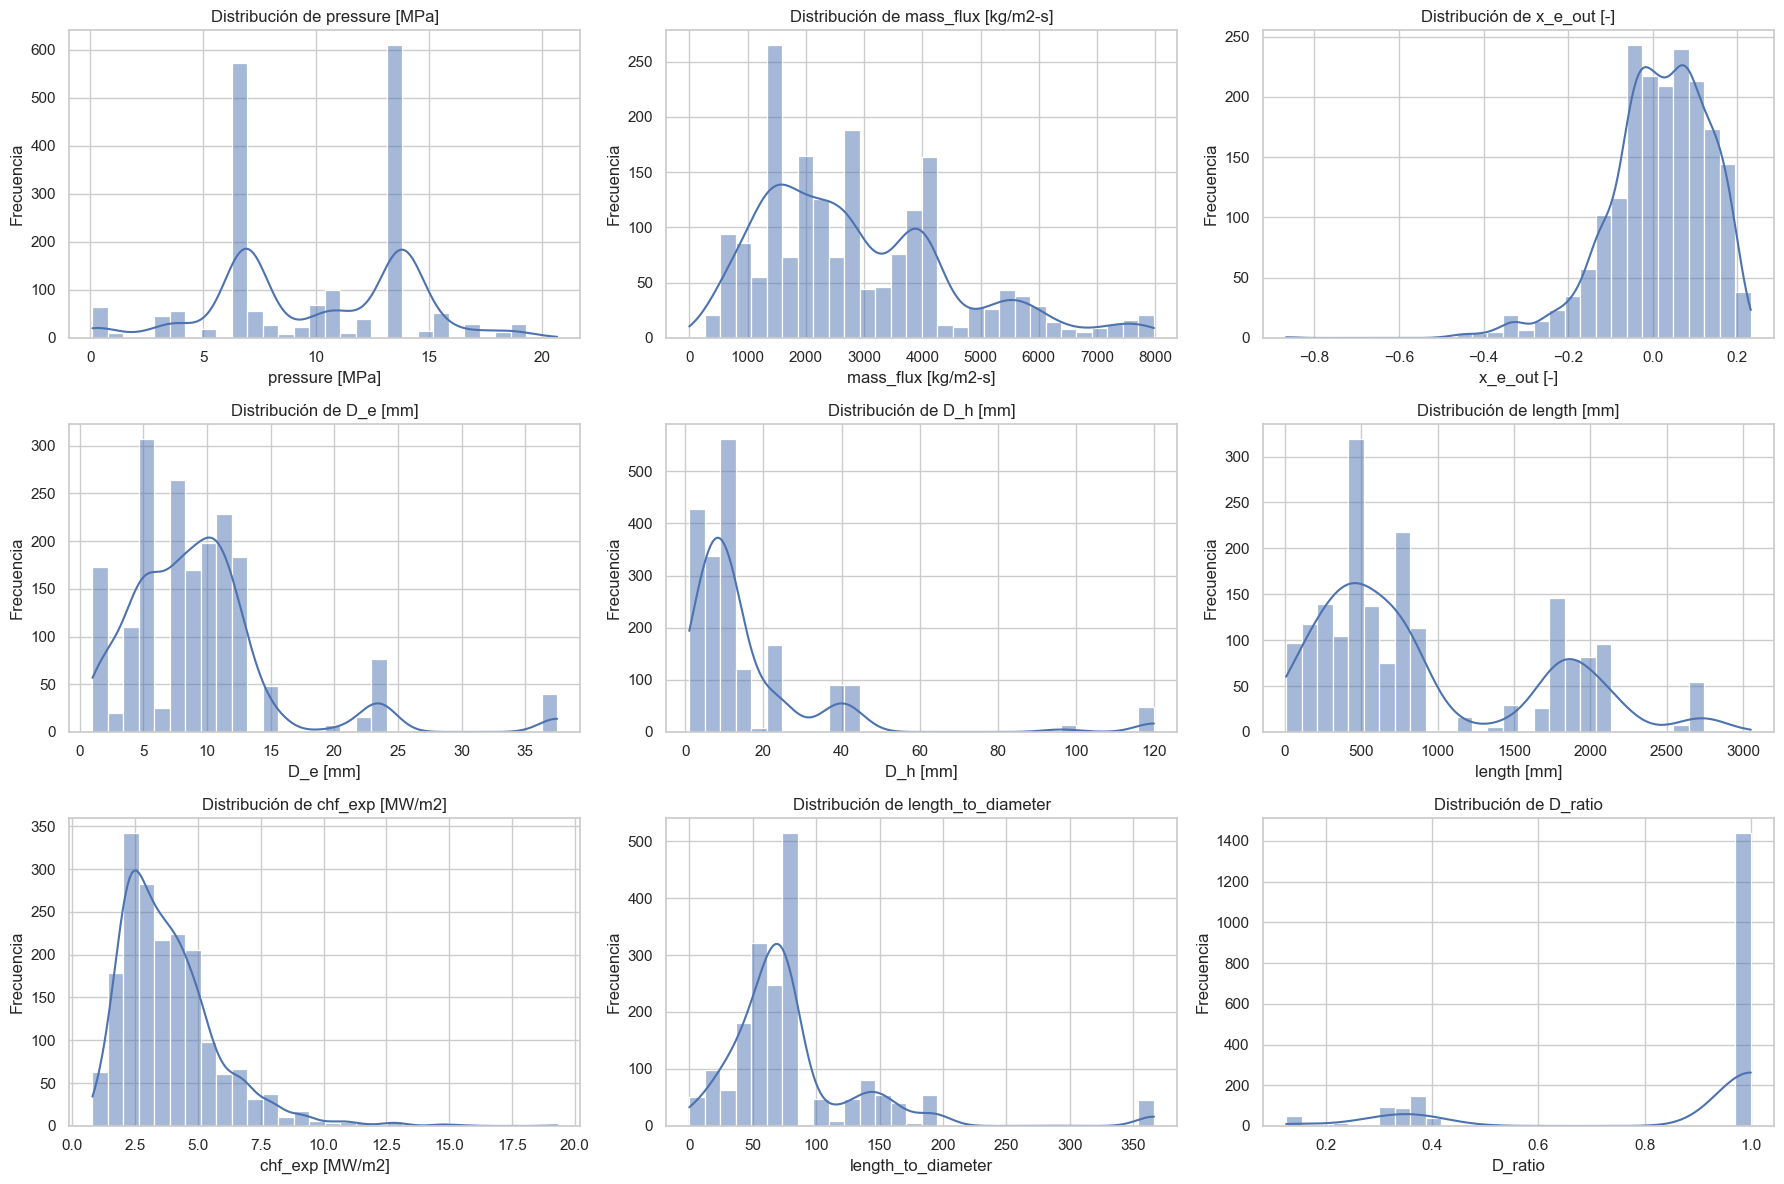

In [43]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()


# Plotting histograms for each numerical column
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], ax=axes[i], kde=True, bins=30)
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Modelos de Machine Learning

En esta parte vamos a correr 4 experimentos, es decir vamos a ejecutar el entrenamiento 4 veces, pero en cada entrenamiendo vamos a cambiar los hiperparametros, incluso podemos quitar algunas variables de entrada.
Para el primer de la red neuronal experimento puedes utilizar la configuración que utilizaron en el paper:

> network architecture: optimal configuration = 6/50/50/50/1 (the input layer has 6 units, each of the 3 hidden layers has 50 units, and the output layer has 1 unit); convergence was reached after 600–800 epochs  (pagina 5)


En formato Markdown vamos a crear un registro de experimentos, el objetivo es dejar constancia de los hiperparametros utilizados en cada experimento, y las metricas de evaluacion obtenidas en cada configuración.

Para los diferentes hiperparametros debes investigar en la documentacion de sklearn cuales son los hiperparametros y como se definen en los modelos.

### Separar variables

> **Importante**: es esta sección de seleccion de variables hay libertad para seleccionar las variables numericas con las que quiero entrenar los modelos, incluso pueden variar entre experimentos, si cambio las variables de entrada debe quedar constancia en el registro de 

In [47]:
X = df[['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
        'D_e [mm]', 'D_h [mm]', 'length [mm]', 'length_to_diameter', 'D_ratio']]
y = df['chf_exp [MW/m2]']

In [51]:
# División en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
numeric_features = ['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]',
                    'D_e [mm]', 'D_h [mm]', 'length [mm]', 'length_to_diameter', 'D_ratio']

### Preprocesador

In [55]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features)
])

#### Definicion de Modelos

In [57]:
# Modelos
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'NeuralNetwork': MLPRegressor( hidden_layer_sizes=(50, 50, 50),  # configuración del paper
        activation='relu',
        solver='adam',
        max_iter=800,
        random_state=42)
}

#### Ejecutar Entrenamiento de Modelos

In [59]:
cdf_data = {}
rRMSE_scores = {}
results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Error relativo absoluto
    relative_errors = np.abs((y_test - y_pred) / y_test)
    relative_errors = np.clip(relative_errors, 0, 1)  # Evitar errores extremos por valores cercanos a cero
    cdf_data[name] = np.sort(relative_errors)

    # Cálculo de rRMSE
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    mean_y = np.mean(y_test)
    rrmse = (rmse / mean_y) * 100
    rRMSE_scores[name] = rrmse

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'rRMSE (%)': rrmse
    })
    
results_df = pd.DataFrame(results)
results_df

,Model,MAE,RMSE,rRMSE (%)
0,LinearRegression,0.762859,1.279955,33.673522
1,RandomForest,0.315225,0.485823,12.781217
2,NeuralNetwork,0.317271,0.330441,8.693361


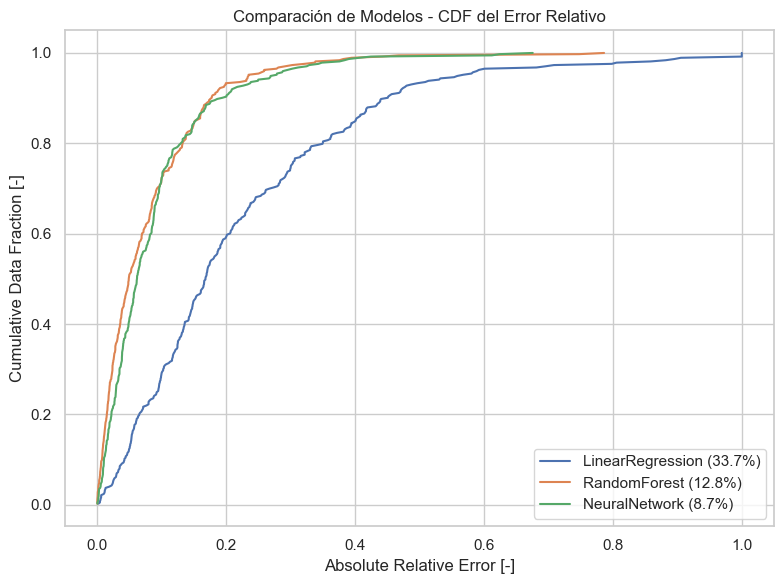

In [61]:
plt.figure(figsize=(8, 6))
for name, errors in cdf_data.items():
    cdf = np.arange(1, len(errors) + 1) / len(errors)
    plt.plot(errors, cdf, label=f"{name} ({rRMSE_scores[name]:.1f}%)")

plt.xlabel("Absolute Relative Error [-]")
plt.ylabel("Cumulative Data Fraction [-]")
plt.title("Comparación de Modelos - CDF del Error Relativo")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

> Compara esta grafica con la de resultados en el paper en la pagina 5, comenta acerca de los modelos

## Comparación de Resultados: Modelos Propios vs Paper

### Resultados Propios

**Modelos evaluados:**
- **Linear Regression:** rRMSE ≈ 33.7%
- **Random Forest:** rRMSE ≈ 12.8%
- **Neural Network:** rRMSE ≈ 8.7%

**Observaciones:**
- La regresión lineal muestra un desempeño significativamente inferior. Su curva CDF crece lentamente, indicando errores relativos altos en muchas predicciones.
- El modelo Random Forest mejora considerablemente, pero sigue superado por la red neuronal.
- La red neuronal es la más precisa: no solo tiene el menor rRMSE, también su CDF alcanza rápidamente fracciones altas de datos con errores bajos.

---

### Resultados del Paper (Figuras (a) y (b), página 5)

**Modelos evaluados en el paper:**
- NN, NN+LUT, RF, RF+LUT, LUT, Liu

**rRMSE reportados:**
- **Figura (a):**
  - NN: 13.6%
  - NN+LUT: 6.5%
  - RF: 13.5%
  - RF+LUT: 6.3%
  - LUT: 12.0%
- **Figura (b):**
  - Liu: 30.9% (peor desempeño)

**Observaciones:**
- Los modelos que combinan redes neuronales o random forests con **tablas de búsqueda (LUT)** alcanzan los mejores resultados (rRMSE ≈ 6.3%–6.5%).
- El modelo de Liu tiene el peor desempeño, similar a la regresión lineal en los resultados propios.
- Las curvas CDF para modelos con LUT crecen más rápido, lo que indica mayor precisión.

---

### Comparación General

- Tu **red neuronal (rRMSE = 8.7%)** se acerca mucho al rendimiento de los modelos híbridos NN+LUT o RF+LUT del paper (≈6.3%–6.5%), a pesar de no usar LUT.
- El **Random Forest (12.8%)** es competitivo, pero con margen de mejora.
- **Regresión lineal** es claramente la opción menos efectiva, tanto en tu experimento como en el paper.

---

### Conclusión

Tu modelo de red neuronal muestra un desempeño muy sólido. Con un refinamiento adicional, como el uso de **Lookup Tables** o ajuste fino de hiperparámetros, podría incluso alcanzar o superar los resultados del estado del arte reportados en el paper.


### Entrenenado un modelo de Redes Neuronales

Utiliza la mejor configuracion de hiperparametros encontrada en el entrenamiento anterior

In [64]:
# Definir features y target
X = df[numeric_features]
y = df['chf_exp [MW/m2]']

# Separar en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Columnas numéricas y categóricas
numeric_features = ['pressure [MPa]', 'mass_flux [kg/m2-s]', 'x_e_out [-]', 
                    'D_e [mm]', 'D_h [mm]', 'length [mm]', 'length_to_diameter', 'D_ratio']

# Preprocesador
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features)
])


In [66]:
# Red neuronal con arquitectura del paper
mlp_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', MLPRegressor(hidden_layer_sizes=(50, 50, 50), max_iter=800, random_state=42))
])

# Entrenar
mlp_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['pressure [MPa]',
                                                   'mass_flux [kg/m2-s]',
                                                   'x_e_out [-]', 'D_e [mm]',
                                                   'D_h [mm]', 'length [mm]',
                                                   'length_to_diameter',
                                                   'D_ratio'])])),
                ('mlp',
                 MLPRegressor(hidden_layer_sizes=(50, 50, 50), max_iter=800,
                              random_state=42))])

In [72]:
# Predecir
y_pred = mlp_model.predict(X_test)


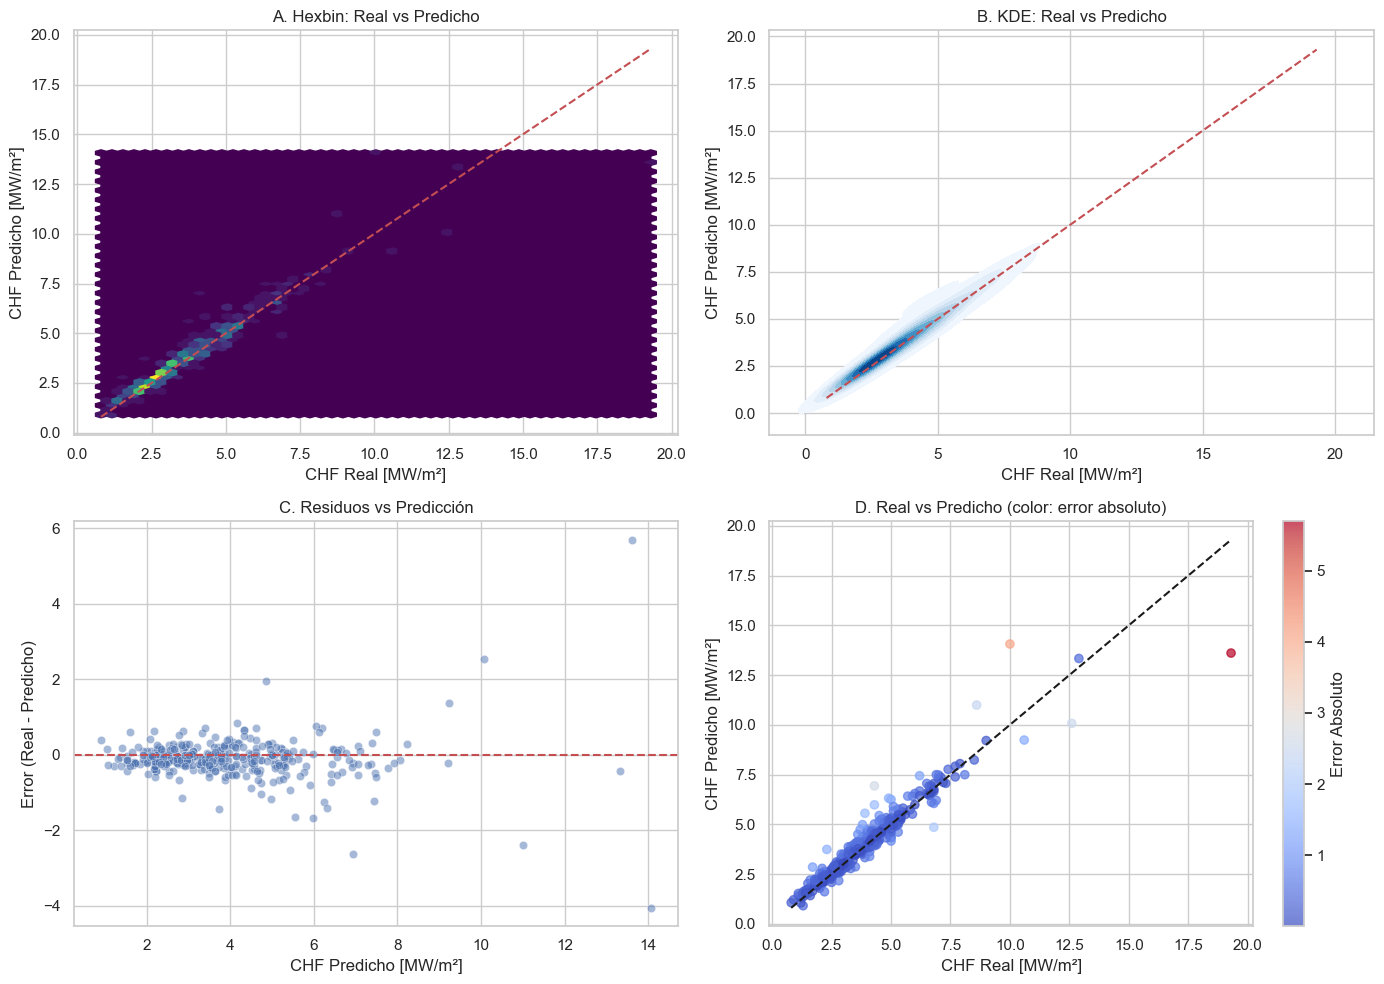

In [74]:
residuals = y_test - y_pred
abs_error = np.abs(residuals)

# Crear figura con 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# A: Hexbin plot
axes[0, 0].hexbin(y_test, y_pred, gridsize=50, cmap='viridis')
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 0].set_title('A. Hexbin: Real vs Predicho')
axes[0, 0].set_xlabel("CHF Real [MW/m²]")
axes[0, 0].set_ylabel("CHF Predicho [MW/m²]")

# B: KDE scatter plot (color por densidad)
sns.kdeplot(x=y_test, y=y_pred, fill=True, cmap='Blues', ax=axes[0, 1])
axes[0, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axes[0, 1].set_title('B. KDE: Real vs Predicho')
axes[0, 1].set_xlabel("CHF Real [MW/m²]")
axes[0, 1].set_ylabel("CHF Predicho [MW/m²]")

# C: Residual plot
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5, ax=axes[1, 0])
axes[1, 0].axhline(0, color='r', linestyle='--')
axes[1, 0].set_title('C. Residuos vs Predicción')
axes[1, 0].set_xlabel("CHF Predicho [MW/m²]")
axes[1, 0].set_ylabel("Error (Real - Predicho)")

# D: Colorear por error absoluto
scatter = axes[1, 1].scatter(y_test, y_pred, c=abs_error, cmap='coolwarm', alpha=0.7)
axes[1, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
axes[1, 1].set_title('D. Real vs Predicho (color: error absoluto)')
axes[1, 1].set_xlabel("CHF Real [MW/m²]")
axes[1, 1].set_ylabel("CHF Predicho [MW/m²]")
fig.colorbar(scatter, ax=axes[1, 1], label='Error Absoluto')

plt.tight_layout()
plt.show()

> Escribe una interpretación de las graficas.

## Interpretación de los Resultados de la Red Neuronal

### A. Hexbin: Real vs Predicho
- **¿Qué muestra?**  
  Una gráfica de densidad por celdas hexagonales, donde cada hexágono representa la cantidad de puntos en esa zona del gráfico.

- **Interpretación:**  
  La mayoría de las predicciones se agrupan cerca de la línea roja discontinua (`y = x`), lo que indica que el modelo predice valores cercanos a los reales en muchos casos. Sin embargo, hay cierta dispersión, especialmente en los extremos, lo que sugiere que el modelo puede tener dificultades para predecir correctamente valores muy bajos o muy altos de CHF.

---

### B. KDE: Real vs Predicho
- **¿Qué muestra?**  
  Una gráfica de densidad suavizada (Kernel Density Estimation), donde las zonas más oscuras representan mayor concentración de puntos.

- **Interpretación:**  
  La mayor densidad se encuentra cerca de la diagonal ideal (`y = x`), lo cual refuerza que el modelo tiene un buen desempeño general. Sin embargo, la dispersión de las curvas de densidad alrededor de la diagonal sugiere errores en algunos rangos de CHF, especialmente para valores más altos.

---

### C. Residuos vs Predicción
- **¿Qué muestra?**  
  Un diagrama de dispersión donde el eje vertical representa el error de predicción (`residuo = real - predicho`).

- **Interpretación:**  
  La mayoría de los residuos están cerca de cero, lo cual es deseable. Sin embargo, se observa cierta heterocedasticidad (el error tiende a aumentar con el valor predicho), indicando que el modelo se vuelve menos preciso para valores de CHF más altos. También pueden observarse algunos outliers o errores sistemáticos.

---

### D. Real vs Predicho (color: error absoluto)
- **¿Qué muestra?**  
  Un gráfico de dispersión de predicciones coloreadas según el error absoluto.

- **Interpretación:**  
  Los puntos cercanos a la diagonal están en tonos fríos (bajo error), mientras que los puntos más alejados están en tonos cálidos (alto error). Se confirma que los errores tienden a aumentar a medida que se predicen valores más altos de CHF.

---

### Resumen General
La red neuronal captura adecuadamente la relación entre las variables de entrada y la salida `CHF`, especialmente en rangos medios. Sin embargo, el modelo tiene más dificultades al predecir valores extremos. Esto sugiere oportunidades de mejora mediante:
- Mayor cantidad de datos en los extremos.
- Técnicas de regularización.
- Modelos híbridos o más complejos.